In [3]:
!pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------------- 625.1/625.1 kB 19.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------------------- -- 2.6/2.8 MB 55.8 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 44.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   --------------------------------------- 301.8/301.8 kB 19.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   --------- ------------------------------ 2.6/10.9 MB 54.5 MB/s eta 0:00:01
   ------------------- -------------------- 5.4/10.9 MB 57.6 MB/s eta 0:00:01
   ------------------------------ --------- 8.3/10.9 MB 59.0 MB/s eta 0:00:01
   ---------------------------------------  10.9/10.9 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------  10.9/10.9 MB 59.5 MB/s eta 0:00:01
   ----------


[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from bcb import sgs
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import auto_arima

In [5]:
warnings.simplefilter("ignore")

SARIMA
==============

In [6]:
ipca = sgs.get(('IPCA', 433))
ipca = ipca[ipca.index >= '2000-01-01']

ipca

,IPCA
Date,
2000-01-01,0.62
2000-02-01,0.13
2000-03-01,0.22
2000-04-01,0.42
2000-05-01,0.01
...,...
2024-02-01,0.83
2024-03-01,0.16
2024-04-01,0.38


In [23]:
planilha = pd.read_excel("C:\\Users\\Enrico\\Downloads\\Juros Reais2.xlsx", header=0)
planilha['year_month'] = pd.to_datetime(planilha['year_month'], format='%Y-%m')
planilha.set_index('year_month', inplace=True)

planilha2 = planilha[['CPI EUA']].copy()
planilha3 = planilha[['CPI CHI']].copy()
planilha4 = planilha[['CPI UK']].copy()
planilha5 = planilha[['CPI CAN']].copy()
planilha6 = planilha[['CPI BR']].copy()


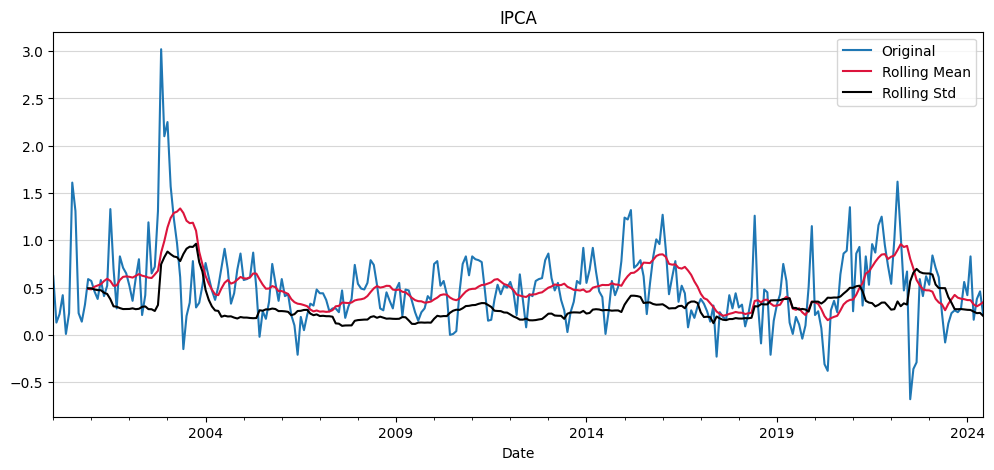

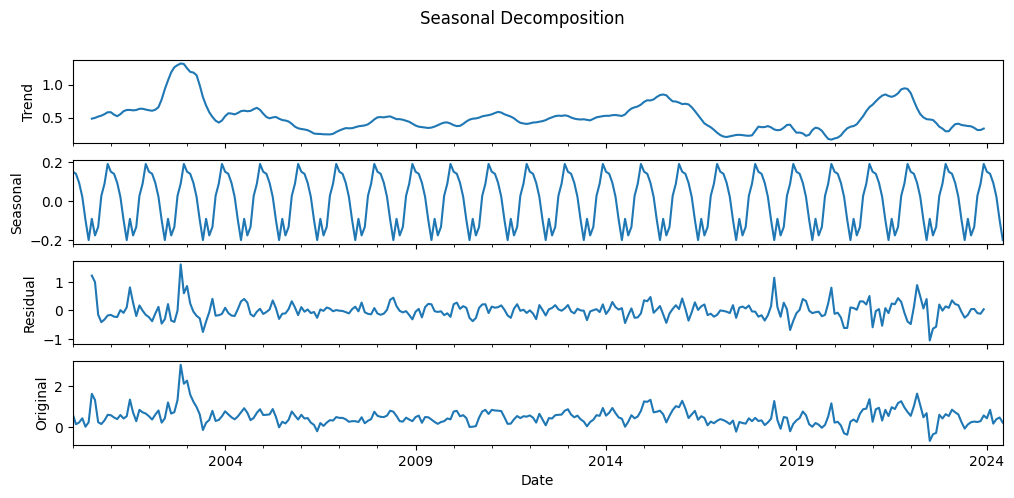

In [8]:
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('IPCA')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()
        
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(ipca['IPCA'])

In [9]:
def adf_test(series):    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(ipca['IPCA'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -8.226833
2. P-value: 0.000000
3. Used Lags: 0
4. Used Observations: 293
5. Critical Values:
	1%: -3.452867
	5%: -2.871455
	10%: -2.572053

Strong evidence against the null hypothesis (H0), reject the null hypothesis.        Data has no unit root and is stationary.


In [10]:
def find_optimal_orders(series, verbose=True):
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    # Start timer
    start_time = time.time()
    
    ######### List of possible combinations
    order_list = [(p, d, q) for p in range(0, 3) for d in range(0, 2) for q in range(0, 3)]
    
    ######### Initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### Loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(seasonal_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except Exception as e:
                print(f'Error while fitting model SARIMAX{param}{param_seasonal[:-1]}: {e}')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))
    
    # Stop timer and display execution time
    diff = time.time() - start_time
    print('\n(Total time of execution: {:.0f} min {:.2f} s)'.format(diff // 60, diff % 60))

In [11]:
find_optimal_orders(ipca['IPCA'], verbose = True)

Expected Fits: 324
========== SARIMAX Results ==========

1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 573.186314,	BIC = 576.866486
2. SARIMAX(0, 0, 0)(0, 0, 1)[12],	AIC = 450.264581,	BIC = 457.541290
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 408.824679,	BIC = 419.608813
4. SARIMAX(0, 0, 0)(0, 1, 0)[12],	AIC = 424.103381,	BIC = 427.741736
5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 287.525241,	BIC = 294.714664
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 229.120730,	BIC = 239.767958
7. SARIMAX(0, 0, 0)(1, 0, 0)[12],	AIC = 373.774742,	BIC = 381.058556
8. SARIMAX(0, 0, 0)(1, 0, 1)[12],	AIC = 292.608178,	BIC = 303.523242
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 269.976858,	BIC = 284.355704
10. SARIMAX(0, 0, 0)(1, 1, 0)[12],	AIC = 362.105194,	BIC = 369.302038
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 279.661502,	BIC = 290.445636
12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 201.108843,	BIC = 215.305148
13. SARIMAX(0, 0, 0)(2, 0, 0)[12],	AIC = 337.584144,	BIC = 348.379410
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 

In [13]:
def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    # Determinar a frequência do índice
    if series.index.freq is None:
        series = series.asfreq(pd.infer_freq(series.index))
    
    # Desenvolver o modelo
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # Previsões
    yhat = model_fit.predict(start=series.index[0], end=series.index[-1], typ='levels', dynamic=False).rename('Predict')

    # Previsão e intervalos de confiança 70% e 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # Extrair lista de índices
    indx_list = conf_int_95.index
    
    # Determinar o intervalo de 5 anos para exibir no segundo gráfico
    end_date = series.index[-1]
    start_date_5_years = end_date - pd.DateOffset(years=5)

    # 1º gráfico - taxas reais vs previstas (série completa)
    plt.figure(figsize=(16, 3))
    series.plot(legend=True, label='Real', color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Taxas Reais vs Previsões (Série Completa)')
    plt.legend()
    plt.show()
    
    # 2º gráfico - resultados da previsão (últimos 5 anos)
    plt.figure(figsize=(16, 6))
    series.loc[start_date_5_years:].plot(legend=True, label='Real', color='orange')
    yhat.loc[start_date_5_years:].plot(legend=True, color='green')
    conf_int_95['mean'].loc[start_date_5_years:].plot(legend=True, label='Previsão', color='crimson')
    # Intervalos de confiança 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'].loc[start_date_5_years:], y2=conf_int_95['mean_ci_lower'].loc[start_date_5_years:],
                     alpha=0.4, label='Intervalo de Confiança 95%', linewidth=0)
    # Intervalos de confiança 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'].loc[start_date_5_years:], y2=conf_int_70['mean_ci_lower'].loc[start_date_5_years:],
                     alpha=0.6, label='Intervalo de Confiança 70%', linewidth=0)
    plt.title('Previsão de Inflação (Últimos 5 Anos)')
    plt.legend(loc='upper left')
    plt.show()
    
    # Exibir taxas previstas
    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Previsão [%]'}, axis=1)

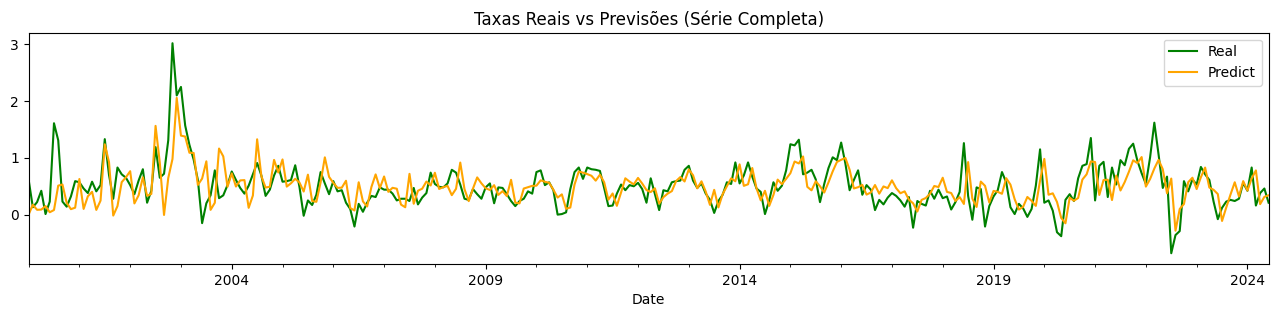

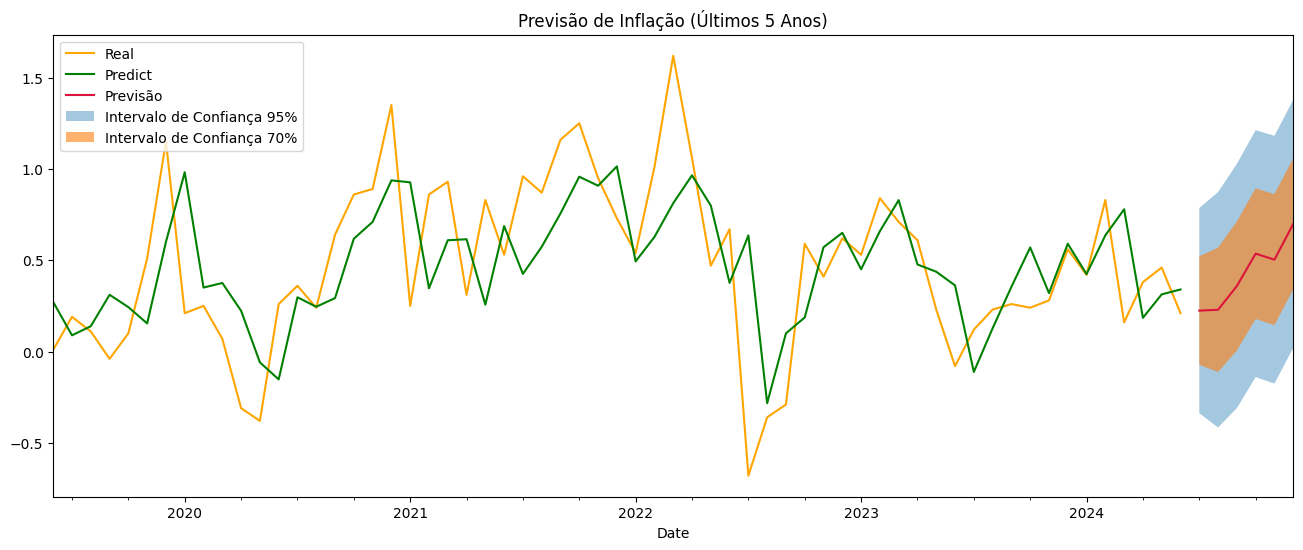

,Previsão [%]
2024-07-01,0.2
2024-08-01,0.2
2024-09-01,0.4
2024-10-01,0.5
2024-11-01,0.5
2024-12-01,0.7


In [14]:
forecast_SARIMA(series=ipca['IPCA'], order=(1, 0, 0), seasonal_order=(1, 1, 2, 12))

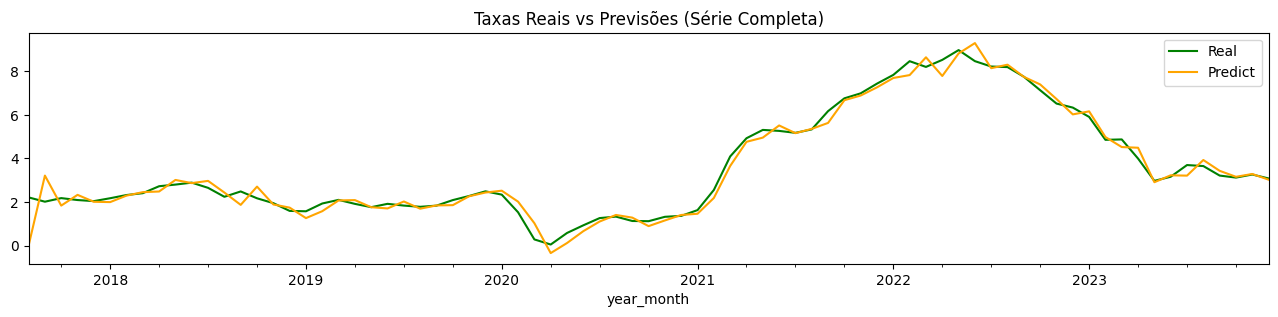

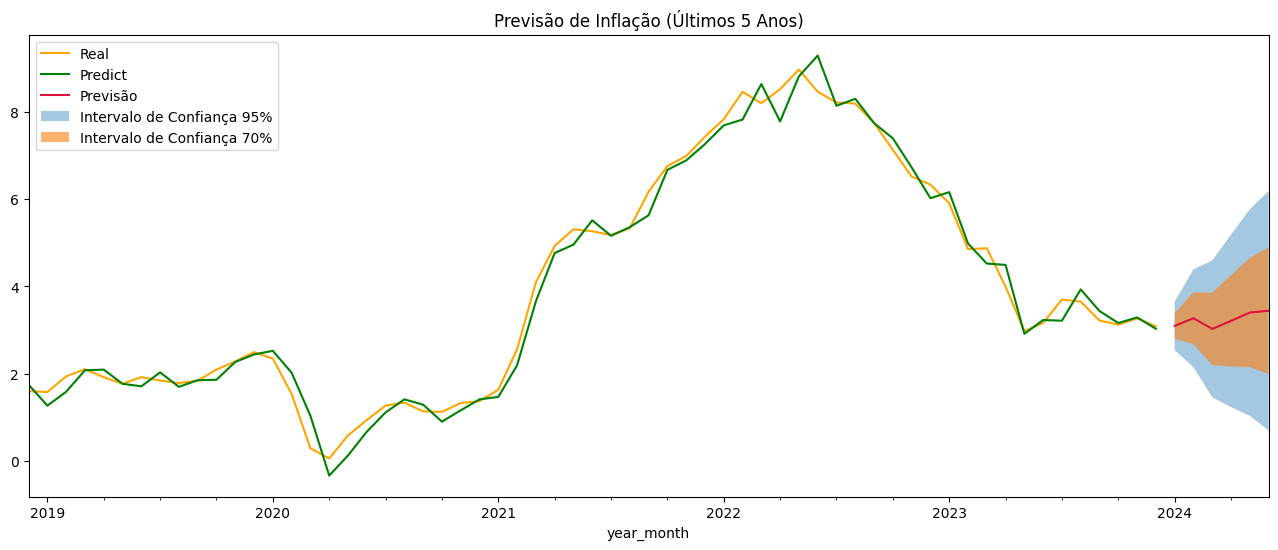

,Previsão [%]
2024-01-01,3.1
2024-02-01,3.3
2024-03-01,3.0
2024-04-01,3.2
2024-05-01,3.4
2024-06-01,3.4


In [11]:
forecast_SARIMA(series=planilha2['CPI EUA'], order=(1, 1, 2), seasonal_order=(0, 0, 1, 12))

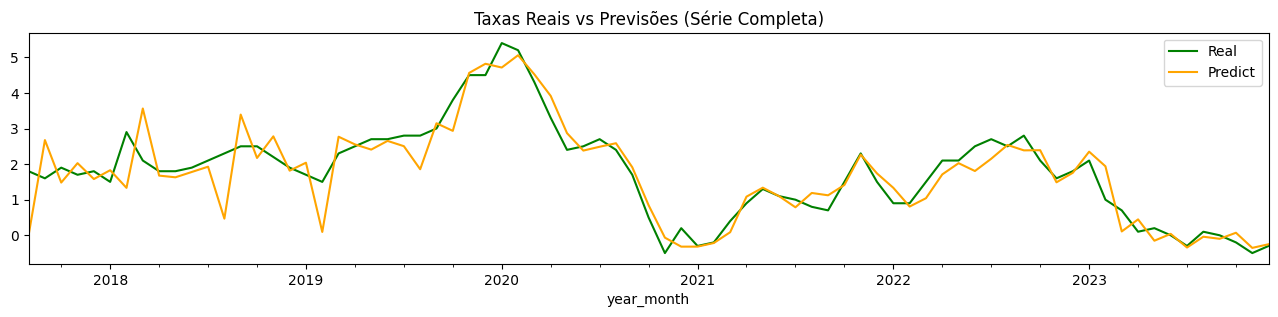

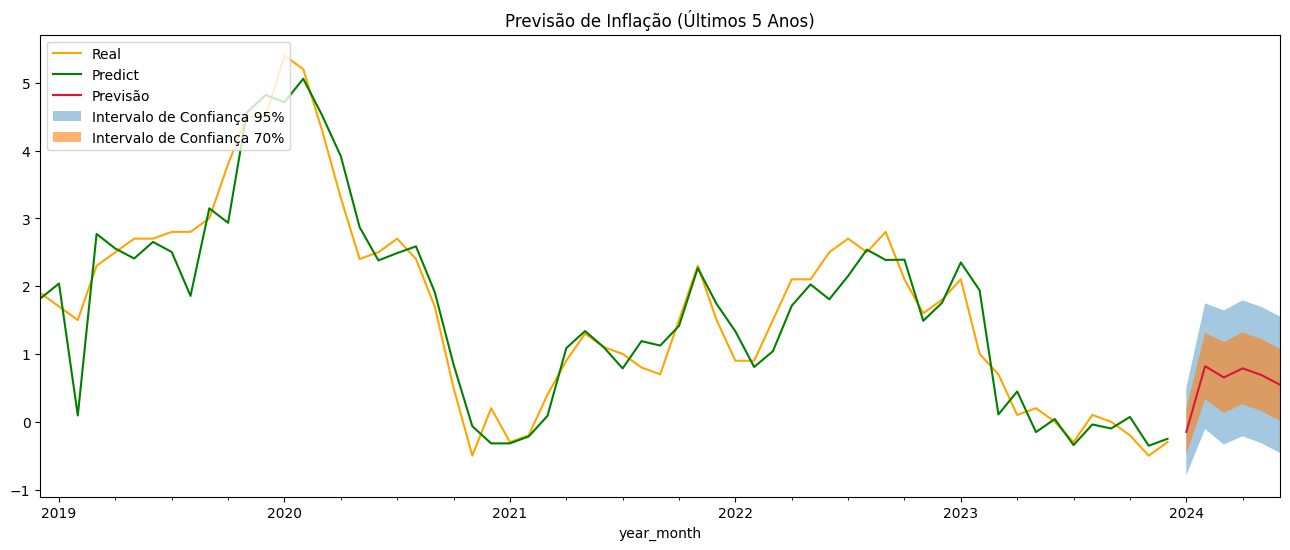

,Previsão [%]
2024-01-01,-0.2
2024-02-01,0.8
2024-03-01,0.7
2024-04-01,0.8
2024-05-01,0.7
2024-06-01,0.5


In [12]:
forecast_SARIMA(series=planilha3['CPI CHI'], order=(2, 0, 2), seasonal_order=(2, 0, 2, 12))

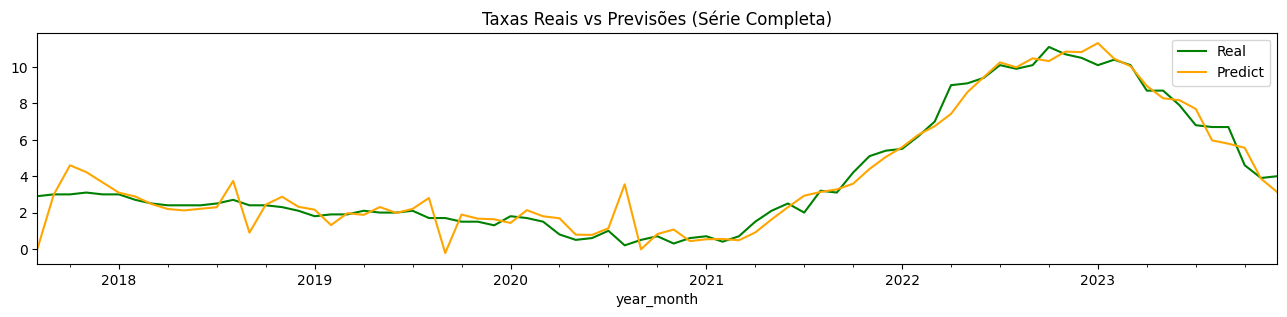

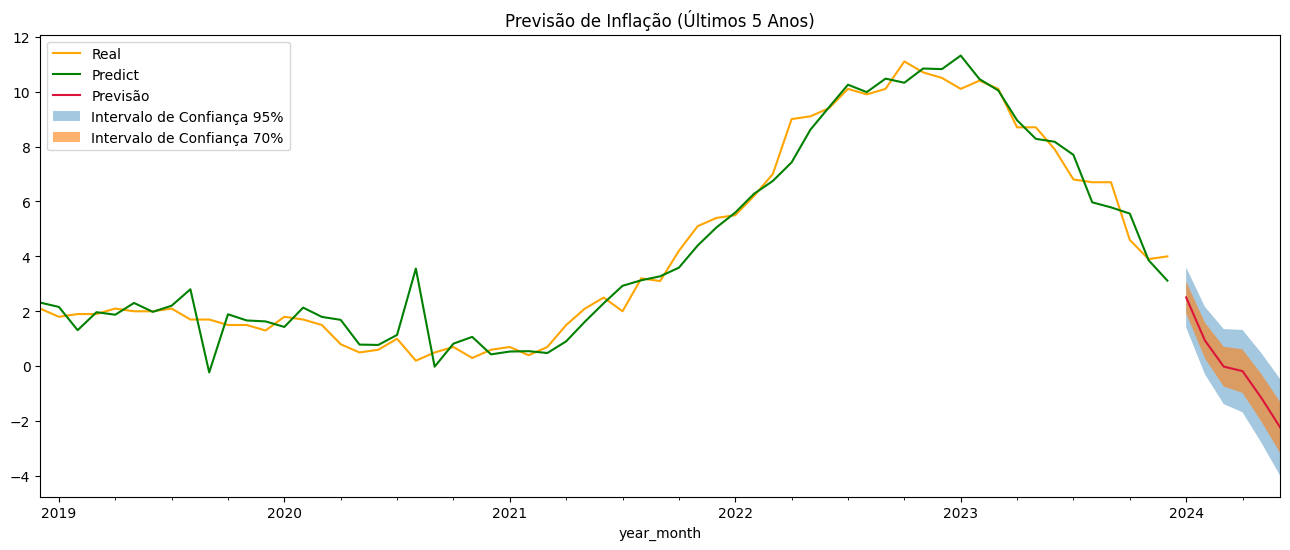

,Previsão [%]
2024-01-01,2.5
2024-02-01,0.9
2024-03-01,-0.0
2024-04-01,-0.2
2024-05-01,-1.1
2024-06-01,-2.2


In [13]:
forecast_SARIMA(series=planilha4['CPI UK'], order=(2, 0, 2), seasonal_order=(2, 1, 0, 12))


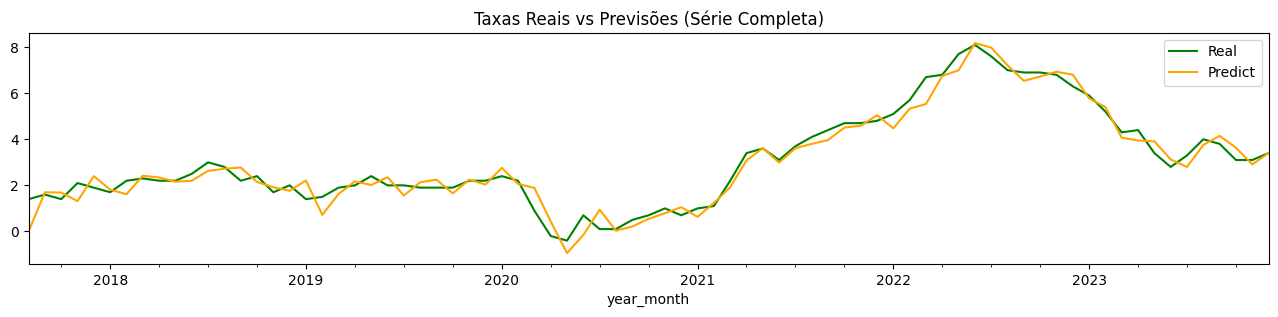

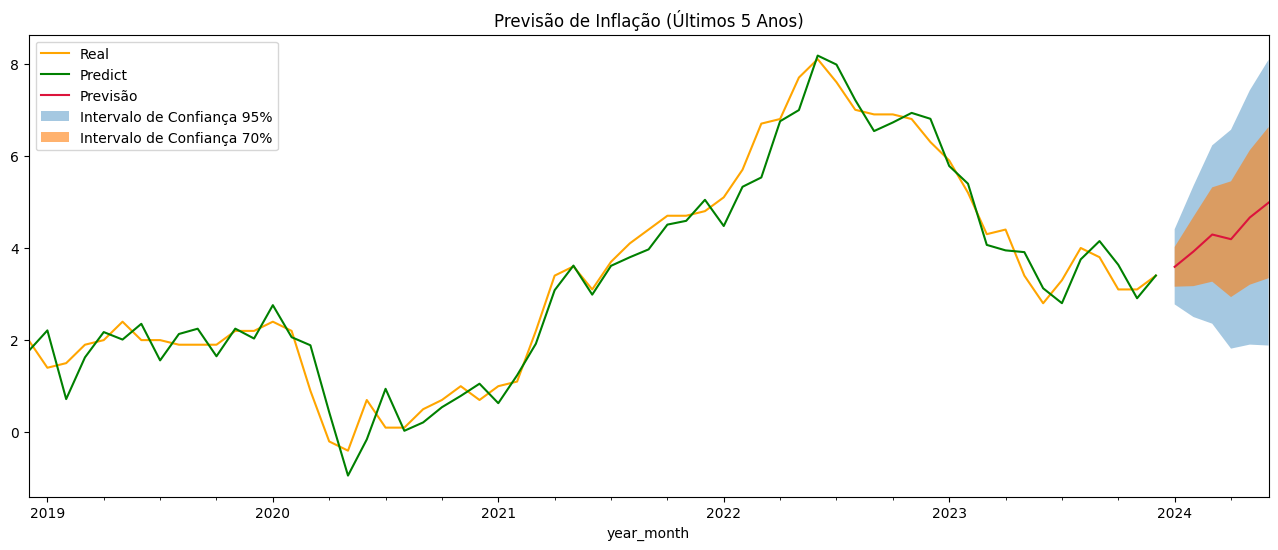

,Previsão [%]
2024-01-01,3.6
2024-02-01,3.9
2024-03-01,4.3
2024-04-01,4.2
2024-05-01,4.7
2024-06-01,5.0


In [14]:
forecast_SARIMA(series=planilha5['CPI CAN'], order=(1, 1, 0), seasonal_order=(2, 0, 0, 12))

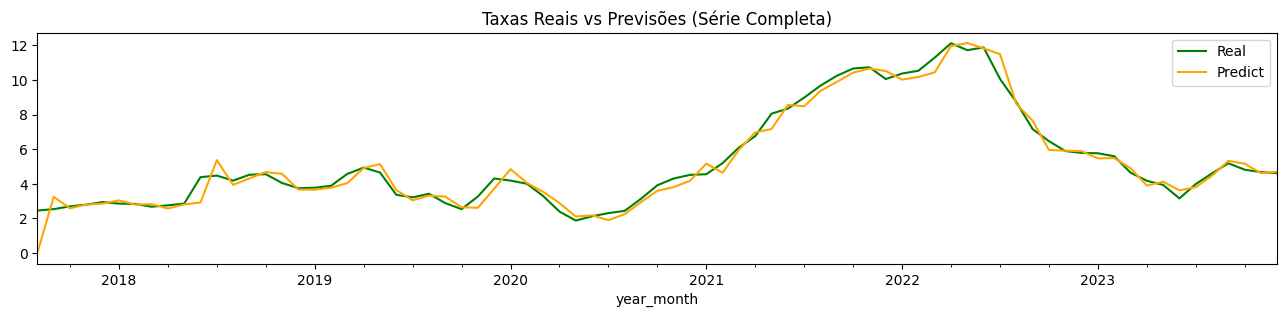

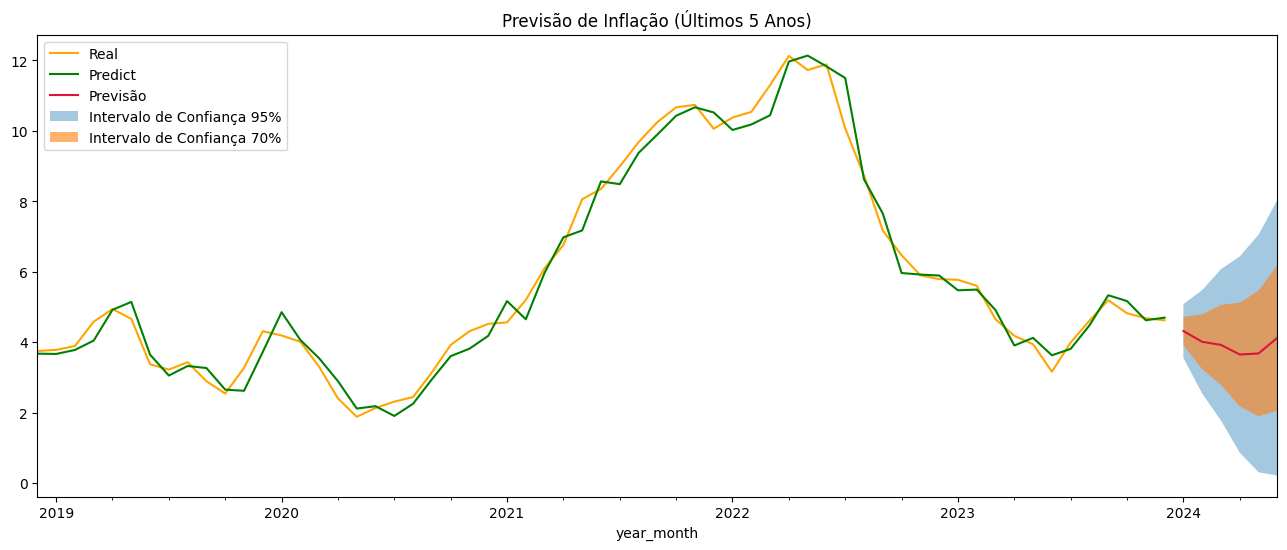

,Previsão [%]
2024-01-01,4.3
2024-02-01,4.0
2024-03-01,3.9
2024-04-01,3.6
2024-05-01,3.7
2024-06-01,4.1


In [15]:
forecast_SARIMA(series=planilha6['CPI BR'], order=(1, 1, 0), seasonal_order=(1, 0, 2, 12))

SARIMAX
==============

In [24]:
file_path = "C:\\Users\\Enrico\\Downloads\\merged.csv"

df = pd.read_csv(file_path, index_col='date.x')
df.head()

,month_year,swap,IPCA,IPCA_lag,ipcaanual,ipca_exp,ipca,selic,juro_real,juro_real_lag,IBC,hiato,hiato_lag,M1
date.x,,,,,,,,,,,,,,
2003-02-01,2003-02,29.44,1.57,2.25,15.847124,0.55,11.56,25.677500,8.485645,9.252171,102.12,0.940647,-0.871086,93602.937
2003-03-01,2003-03,27.62,1.23,1.57,16.572608,0.53,11.01,26.316316,8.358488,8.485645,101.72,0.764971,0.940647,89822.584
2003-04-01,2003-04,25.21,0.97,1.23,16.769209,0.54,9.58,26.319000,8.178347,8.358488,101.08,0.416089,0.764971,87410.599
2003-05-01,2003-05,23.29,0.61,0.97,17.235307,0.49,8.87,26.308095,7.738956,8.178347,99.97,-0.405544,0.416089,86231.763
2003-06-01,2003-06,22.29,-0.15,0.61,16.569860,0.55,8.07,26.086500,8.163894,7.738956,100.14,-0.054145,-0.405544,88466.315


In [30]:
from itertools import product
def find_optimal_ordersX(series, exog=None, verbose=True):
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    # Start timer
    start_time = time.time()
    
    ######### List of possible combinations
    order_list = [(p, d, q) for p in range(0, 3) for d in range(0, 2) for q in range(0, 3)]
    
    ######### Initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### Loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(seasonal_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, exog=exog, order=param, seasonal_order=param_seasonal,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except Exception as e:
                print(f'Error while fitting model SARIMAX{param}{param_seasonal[:-1]}: {e}')
                continue
    
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))
    
    # Stop timer and display execution time
    diff = time.time() - start_time
    print('\n(Total time of execution: {:.0f} min {:.2f} s)'.format(diff // 60, diff % 60))

# Exemplo de chamada da função find_optimal_ordersX com variáveis exógenas
exog_variables = ['swap', 'M1', 'selic', 'IBC', 'hiato']
find_optimal_ordersX(df['IPCA'], exog=exog_variables, verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

Error while fitting model SARIMAX(0, 0, 0)(0, 0, 0): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 0, 1): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 0, 2): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 1, 0): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 1, 1): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 1, 2): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5

TypeError: 'NoneType' object is not subscriptable

In [29]:
exog_variables = ['swap', 'M1', 'selic', 'IBC', 'hiato']
find_optimal_ordersX(df['IPCA'], exog=exog_variables, verbose=True)

Expected Fits: 27
========== SARIMAX Results ==========

Error while fitting model SARIMAX(0, 0, 0)(0, 0, 0): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 0, 1): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 0, 2): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 1, 0): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 1, 1): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None
Error while fitting model SARIMAX(0, 0, 0)(0, 1, 2): ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5'

TypeError: 'NoneType' object is not subscriptable

In [ ]:
endog = df['IPCA']  
exog = df[['ipca_exp', 'hiato','swap', 'juro_real', 'selic','ipcaanual', 'M1'] 

order = (1, 1, 0)  
seasonal_order = (0, 0, 1, 12)

model = sm.tsa.SARIMAX(endog, exog=exog, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

In [ ]:
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps, exog=exog.iloc[-forecast_steps:])
forecast_ci = forecast.conf_int()

print(forecast.predicted_mean)
print(forecast_ci)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(endog.index, endog, label='Observado (IPCA)', color='blue')

plt.plot(results.fittedvalues.index, results.fittedvalues, label='Previsão', color='red')

plt.title('Previsão do IPCA com SARIMAX')
plt.xlabel('Tempo')
plt.ylabel('IPCA')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
###############

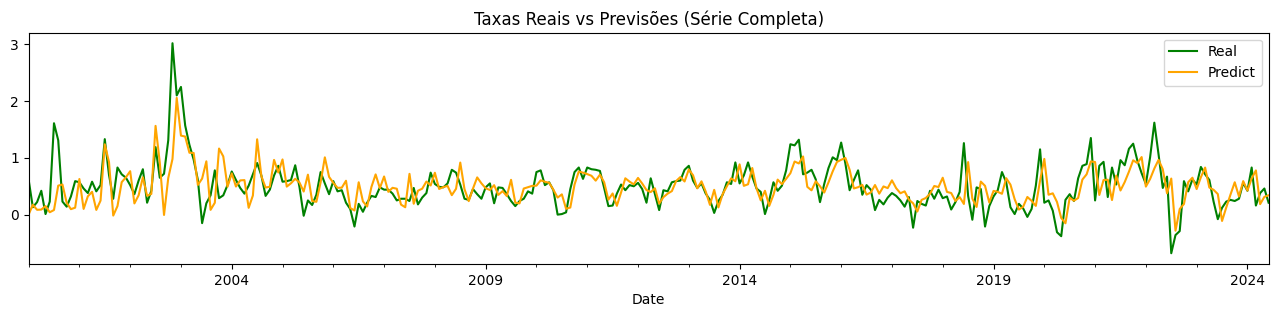

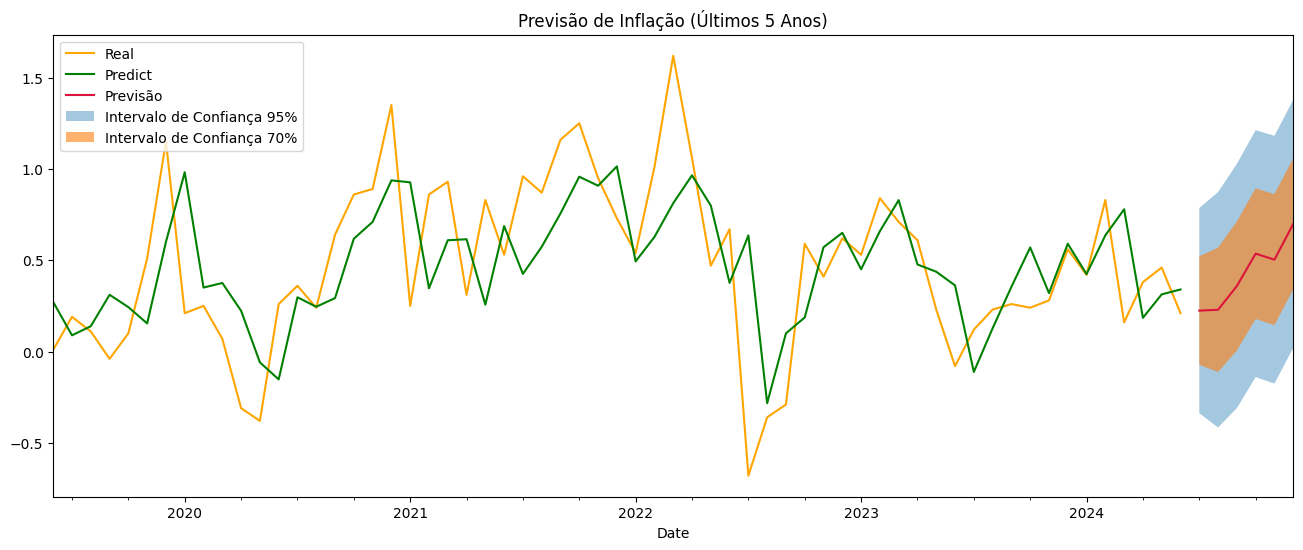

,Previsão [%]
2024-07-01,0.2
2024-08-01,0.2
2024-09-01,0.4
2024-10-01,0.5
2024-11-01,0.5
2024-12-01,0.7


In [15]:
forecast_SARIMA(series=ipca['IPCA'], order=(1, 0, 0), seasonal_order=(1, 1, 2, 12))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=139.616, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=262.433, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=196.083, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=137.821, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=139.649, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=203.228, Time=0.04 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=141.651, Time=0.84 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=139.720, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 3.181 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations: 

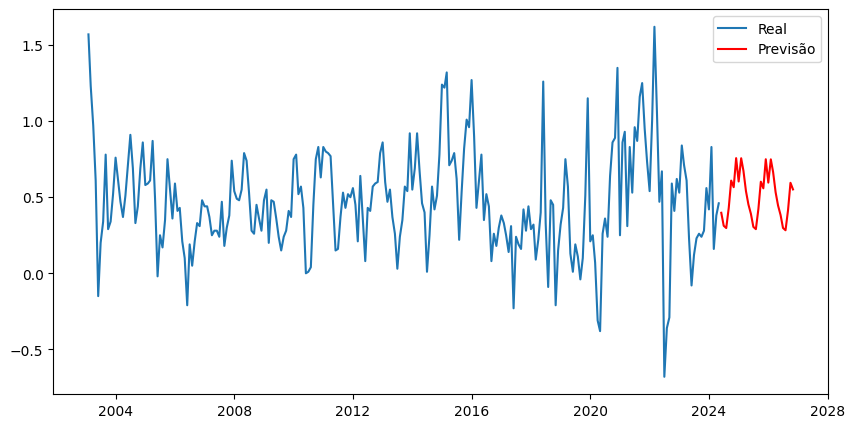

In [41]:
df.index = pd.to_datetime(df.index)

# Treinando o modelo SARIMAX
model_sarimax = auto_arima(df['IPCA'], start_p=0, d=1, start_q=0,
                           max_p=1, max_d=2, max_q=2, start_P=0,
                           D=1, start_Q=2, max_P=2, max_D=1,
                           max_Q=5, m=12, seasonal=True,
                           error_action='warn', trace=True,
                           suppress_warnings=True, stepwise=True,
                           random_state=20, n_fits=50)
print(model_sarimax.summary())

# Prevendo os próximos 30 dias
forecast = model_sarimax.predict(n_periods=30)
print("Previsão:", forecast)

# Criando um índice de datas para o período de previsão
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=30, freq='MS')
print("Índice da previsão:", forecast_index)

# Convertendo a previsão para uma Series para facilitar o plot
forecast_series = pd.Series(forecast, index=forecast_index)
print("Série da previsão:", forecast_series)

# Plotando os dados reais e a previsão
plt.figure(figsize=(10, 5))
plt.plot(df['IPCA'], label='Real')
plt.plot(forecast_series, label='Previsão', color='red')
plt.legend()
plt.show()

In [50]:
df.index = pd.to_datetime(df.index)

# Suponha que 'exog_vars' seja um DataFrame com suas variáveis exógenas
# e que 'exog_vars' tenha o mesmo índice que 'df'
# Substitua 'exog_vars' pelas suas variáveis exógenas reais
exog_vars = df[['ipca_exp', 'hiato']]  # substitua 'exog1', 'exog2', 'exog3' pelos nomes das suas variáveis exógenas

# Treinando o modelo SARIMAX com variáveis exógenas
model_sarimax = auto_arima(df['IPCA'], exogenous=exog_vars, start_p=0, d=1, start_q=0,
                           max_p=1, max_d=2, max_q=2, start_P=0,
                           D=1, start_Q=2, max_P=2, max_D=1,
                           max_Q=5, m=12, seasonal=True,
                           error_action='warn', trace=True,
                           suppress_warnings=True, stepwise=True,
                           random_state=20, n_fits=50)
print(model_sarimax.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=139.616, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=262.433, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=196.083, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=137.821, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=139.649, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=203.228, Time=0.05 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=141.651, Time=0.83 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=139.720, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 3.327 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations: 

Previsão: 2024-06-01    0.397704
2024-07-01    0.312413
2024-08-01    0.297405
2024-09-01    0.429830
2024-10-01    0.609219
2024-11-01    0.565778
2024-12-01    0.756732
2025-01-01    0.603288
2025-02-01    0.755998
2025-03-01    0.673104
2025-04-01    0.539779
2025-05-01    0.452722
Freq: MS, dtype: float64
Índice da previsão: DatetimeIndex(['2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01',
               '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', freq='MS')
Série da previsão: 2024-06-01    0.397704
2024-07-01    0.312413
2024-08-01    0.297405
2024-09-01    0.429830
2024-10-01    0.609219
2024-11-01    0.565778
2024-12-01    0.756732
2025-01-01    0.603288
2025-02-01    0.755998
2025-03-01    0.673104
2025-04-01    0.539779
2025-05-01    0.452722
Freq: MS, dtype: float64


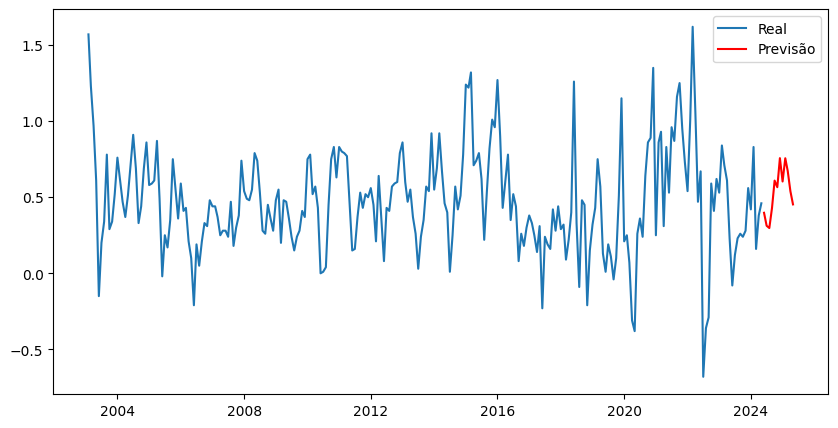

In [52]:
exog_future = pd.DataFrame({
    'ipca_exp': [0.33, 0.1521, 0.1, 0.19,0.29,0.22,0.46,0.42,0.52,0.34,0.35,0.25],
    'swap': [10.8, 10.8, 10.8, 10.8,10.8,10.8,10.8,10.8,10.8,10.8,10.8,10.8]
}, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS'))

forecast = model_sarimax.predict(n_periods=12, exogenous=exog_future)
print("Previsão:", forecast)

# Criando um índice de datas para o período de previsão
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
print("Índice da previsão:", forecast_index)

# Convertendo a previsão para uma Series para facilitar o plot
forecast_series = pd.Series(forecast, index=forecast_index)
print("Série da previsão:", forecast_series)

# Plotando os dados reais e a previsão
plt.figure(figsize=(10, 5))
plt.plot(df['IPCA'], label='Real')
plt.plot(forecast_series, label='Previsão', color='red')
plt.legend()
plt.show()

Vector Autoregression (VAR)
==============

In [56]:
from statsmodels.tsa.api import VAR

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Jul, 2024
Time:                     11:08:44
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    6.06615
Nobs:                     243.000    HQIC:                  0.537581
Log likelihood:          -1381.89    FPE:                  0.0542778
AIC:                     -3.19118    Det(Omega_mle):      0.00573525
--------------------------------------------------------------------
Results for equation swap
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.225261         0.907822           -0.248           0.804
L1.swap               1.268948         0.085054           14.919           0.000
L1.ipca_exp          -1.351747         0.790838           -1.

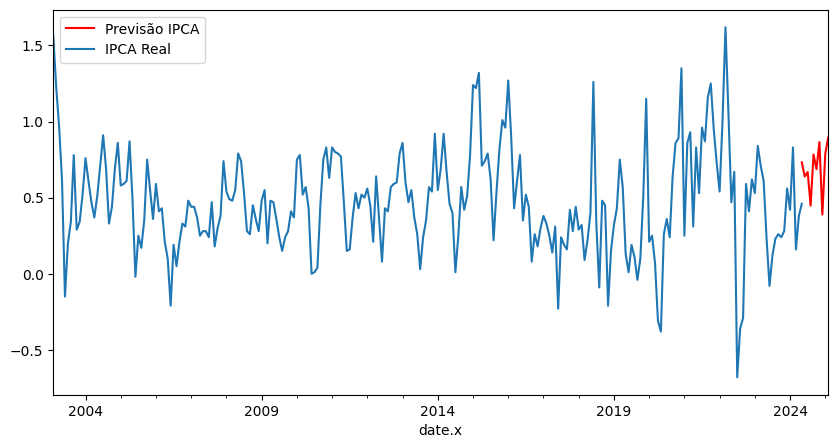

In [62]:
variables = ['swap', 'ipca_exp', 'selic', 'juro_real', 'IBC', 'IPCA', 'M1']
df_var = df[variables]
model = VAR(df_var)
results = model.fit(maxlags=15, ic='aic')

# Resumo do modelo
print(results.summary())

# Fazendo previsões
lag_order = results.k_ar
forecast_input = df_var.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=10, freq='M'), columns=df_var.columns)

# Plotando as previsões
forecast_df['IPCA'].plot(figsize=(10, 5), label='Previsão IPCA', color='red')
df['IPCA'].plot(label='IPCA Real')
plt.legend()
plt.show()

Modelo Estrutural
==============

In [60]:
forecast_df['IPCA']

2024-05-31    0.411252
2024-06-30    0.307572
2024-07-31    0.307312
2024-08-31    0.007642
2024-09-30    0.298577
2024-10-31    0.256260
2024-11-30    0.513313
2024-12-31    0.107834
2025-01-31    0.422164
2025-02-28    0.426412
Freq: ME, Name: IPCA, dtype: float64

In [63]:
forecast_df['IPCA']

2024-05-31    0.732166
2024-06-30    0.638926
2024-07-31    0.668673
2024-08-31    0.447825
2024-09-30    0.783816
2024-10-31    0.687462
2024-11-30    0.864875
2024-12-31    0.388867
2025-01-31    0.788158
2025-02-28    0.896305
Freq: ME, Name: IPCA, dtype: float64

In [81]:
df['M1'] = df['M1'].diff()
df['IBC'] = df['IBC'].diff()
df = df.dropna()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Jul, 2024
Time:                     11:17:26
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    6.20989
Nobs:                     241.000    HQIC:                  0.649483
Log likelihood:          -1375.94    FPE:                  0.0597729
AIC:                     -3.10218    Det(Omega_mle):      0.00621604
--------------------------------------------------------------------
Results for equation swap
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.286334         0.916831           -0.312           0.755
L1.swap               1.261032         0.086187           14.631           0.000
L1.ipca_exp          -1.606739         0.772010           -2.

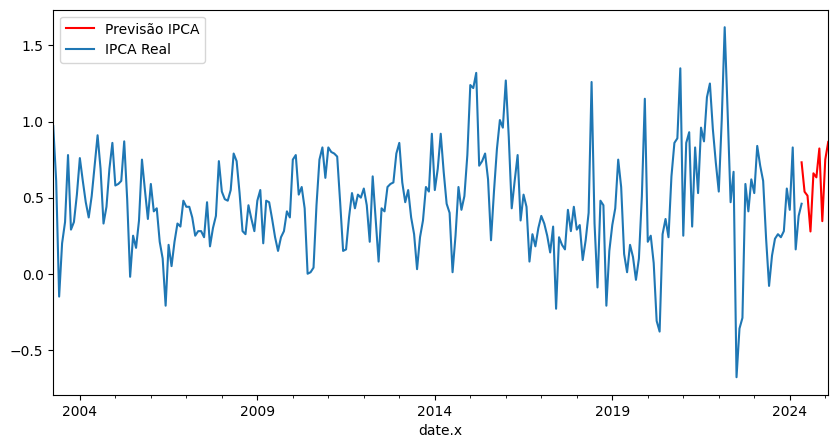

In [70]:
variables = ['swap', 'ipca_exp', 'selic', 'juro_real', 'IBC', 'IPCA', 'M1']
df_var = df[variables]
model = VAR(df_var)
results = model.fit(maxlags=15, ic='aic')

# Resumo do modelo
print(results.summary())

# Fazendo previsões
lag_order = results.k_ar
forecast_input = df_var.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=10, freq='M'), columns=df_var.columns)

# Plotando as previsões
forecast_df['IPCA'].plot(figsize=(10, 5), label='Previsão IPCA', color='red')
df['IPCA'].plot(label='IPCA Real')
plt.legend()
plt.show()

In [72]:
forecast_df['IPCA']

2024-05-31    0.732163
2024-06-30    0.538880
2024-07-31    0.512919
2024-08-31    0.277739
2024-09-30    0.660044
2024-10-31    0.633367
2024-11-30    0.823213
2024-12-31    0.345600
2025-01-31    0.750421
2025-02-28    0.866097
Freq: ME, Name: IPCA, dtype: float64

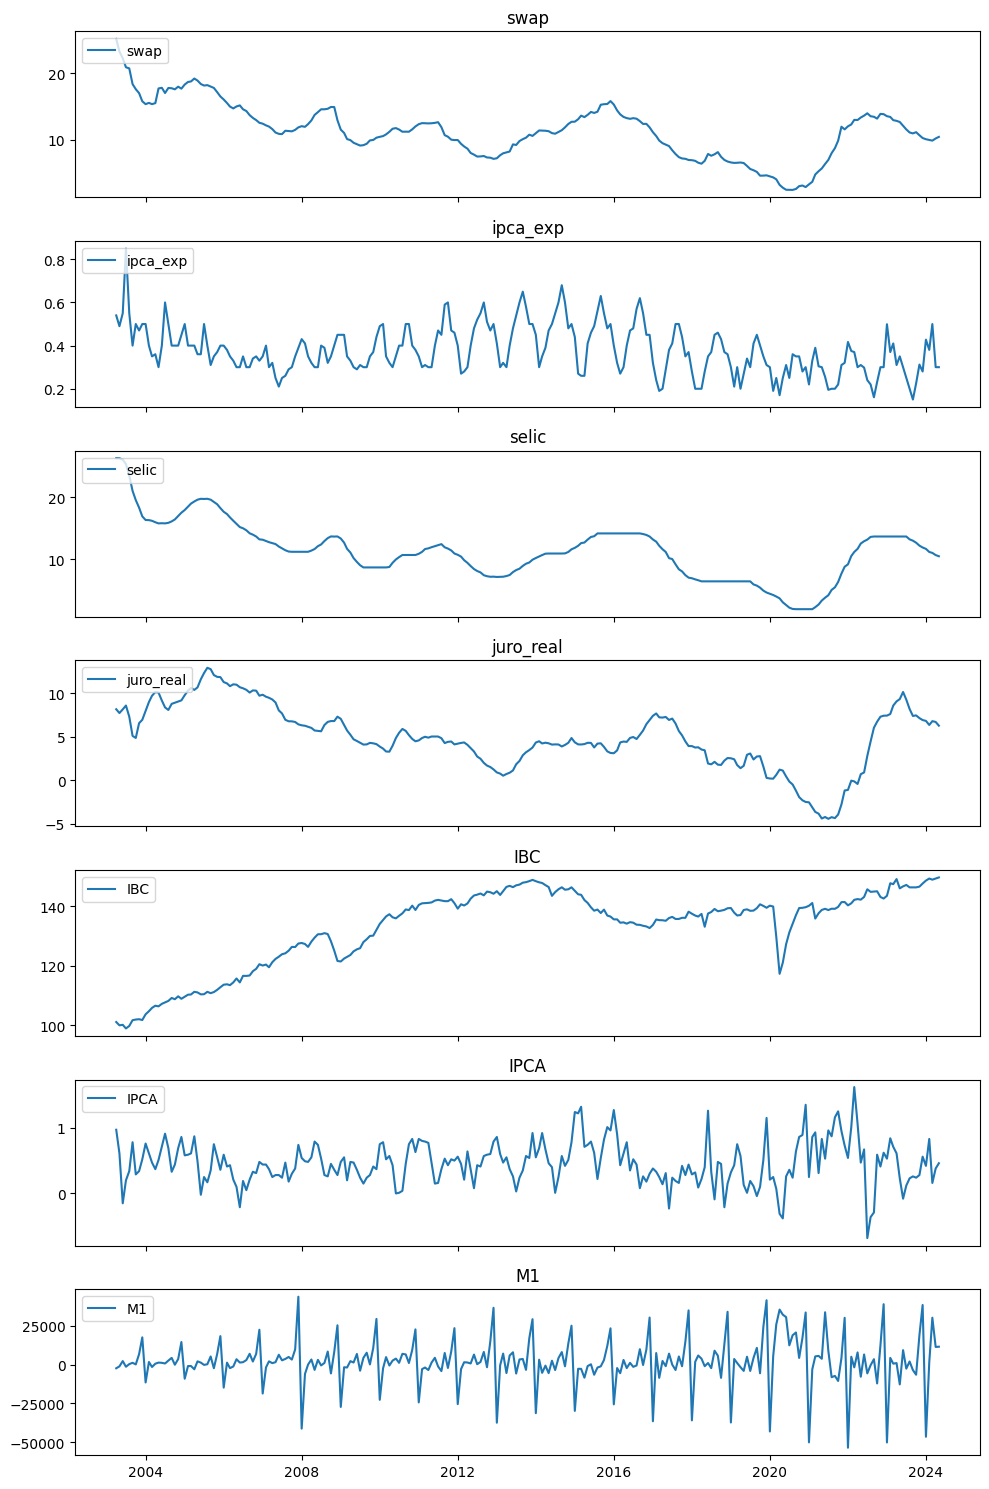

In [73]:
variables = ['swap', 'ipca_exp', 'selic', 'juro_real', 'IBC', 'IPCA', 'M1']

# Criando uma figura e subplots para cada variável
fig, axs = plt.subplots(len(variables), 1, figsize=(10, 15), sharex=True)

# Iterando sobre cada variável para criar um subplot
for i, var in enumerate(variables):
    axs[i].plot(df.index, df[var], label=var)
    axs[i].set_title(var)
    axs[i].legend(loc='upper left')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()
plt.show()

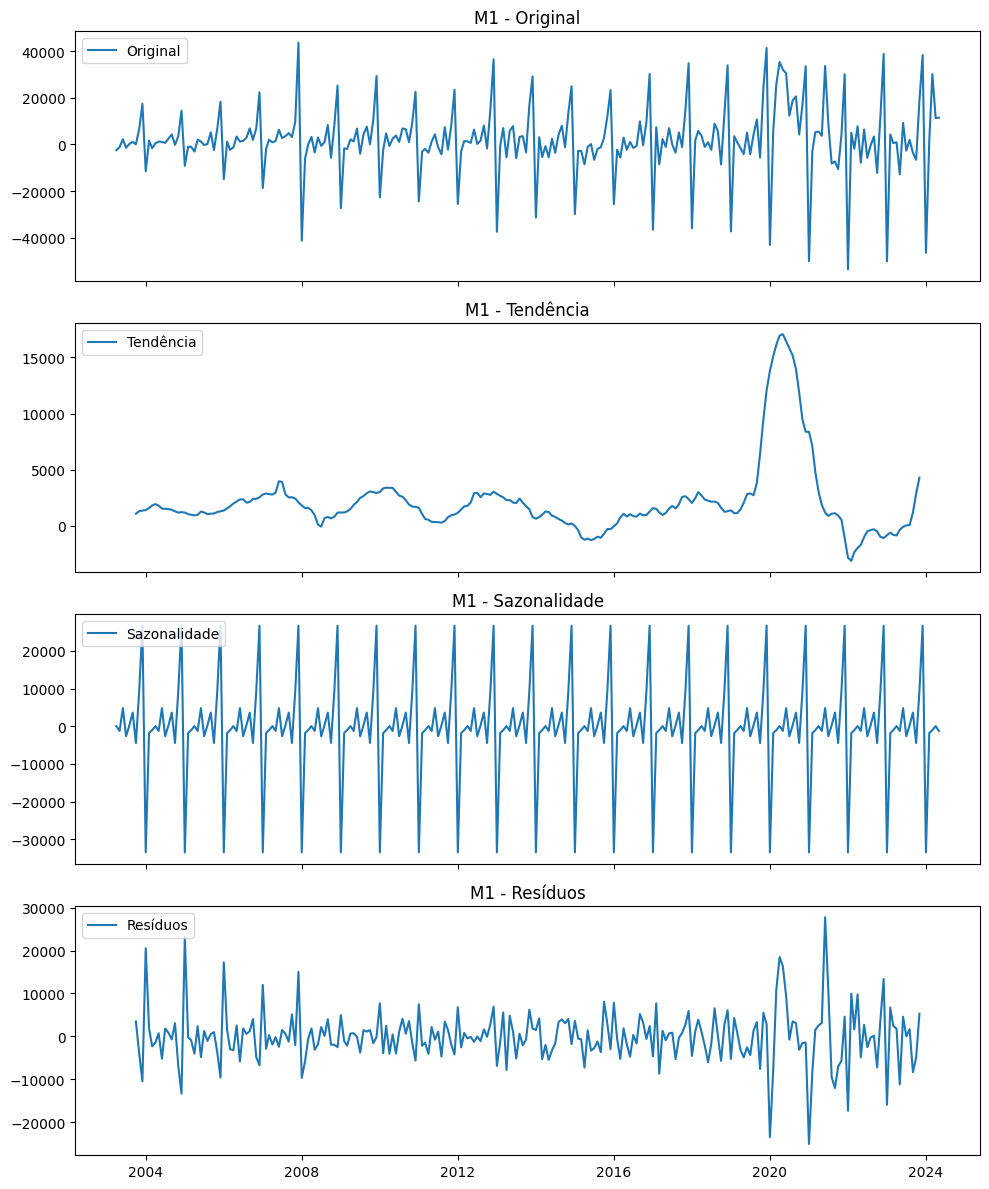

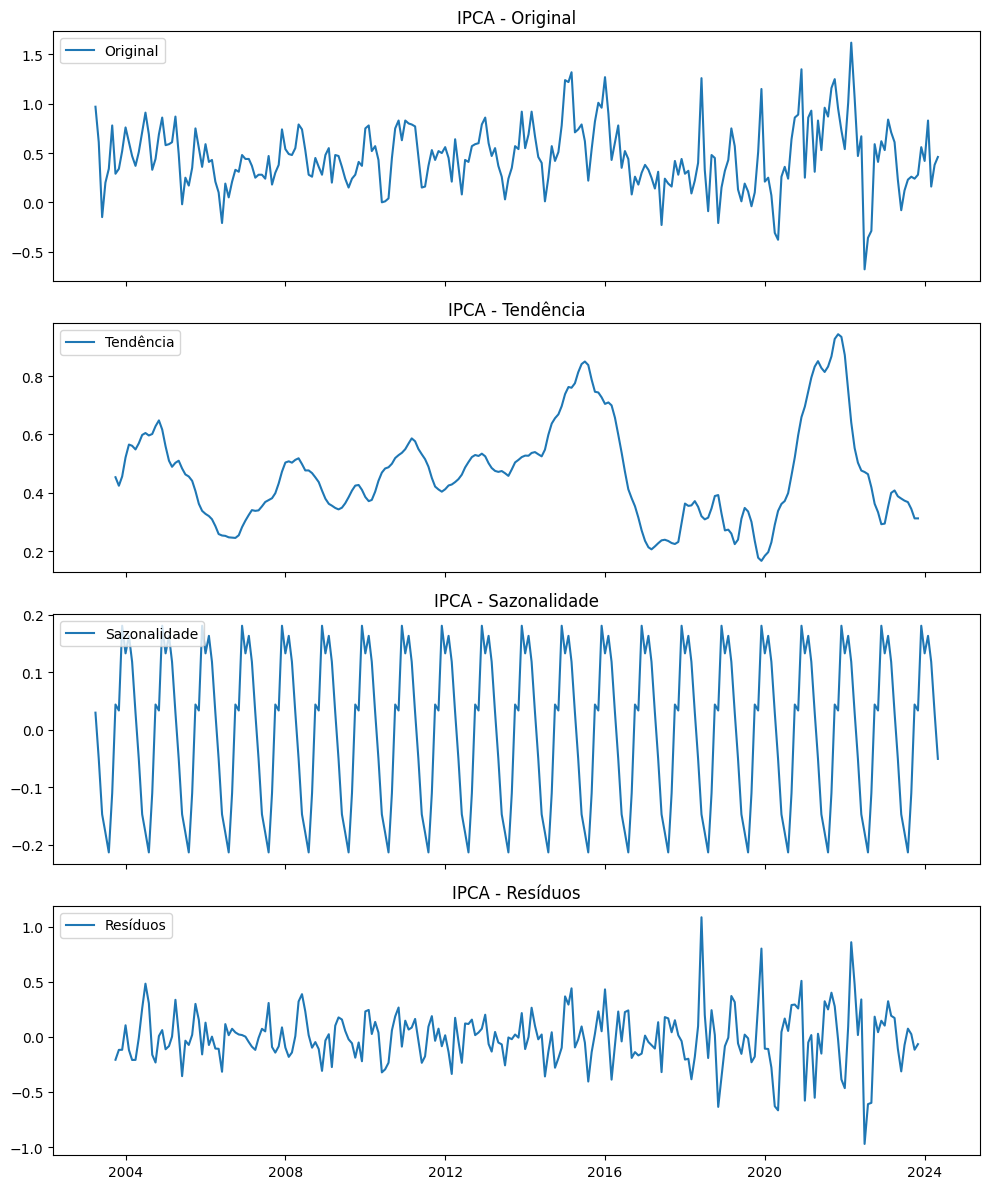

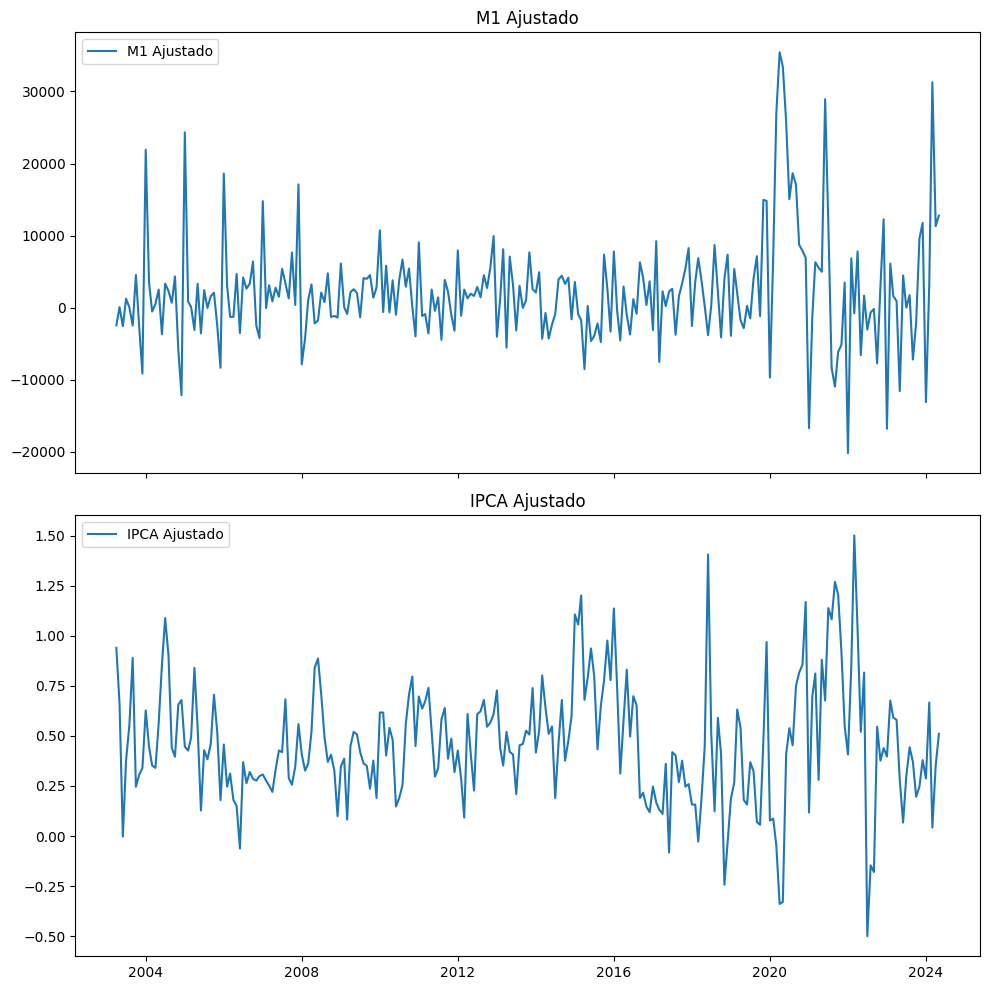

In [74]:
def decompose_and_plot(series, column_name):
    # Decomposição sazonal
    result = seasonal_decompose(series, model='additive', period=12)  # Ajuste o período conforme a sazonalidade esperada

    # Plotar a série original e os componentes
    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
    
    axs[0].plot(series, label='Original')
    axs[0].set_title(f'{column_name} - Original')
    axs[0].legend(loc='upper left')

    axs[1].plot(result.trend, label='Tendência')
    axs[1].set_title(f'{column_name} - Tendência')
    axs[1].legend(loc='upper left')

    axs[2].plot(result.seasonal, label='Sazonalidade')
    axs[2].set_title(f'{column_name} - Sazonalidade')
    axs[2].legend(loc='upper left')

    axs[3].plot(result.resid, label='Resíduos')
    axs[3].set_title(f'{column_name} - Resíduos')
    axs[3].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Decompor e plotar para M1 e IPCA
decompose_and_plot(df['M1'], 'M1')
decompose_and_plot(df['IPCA'], 'IPCA')

# Plotar as séries ajustadas (residuais sem componente sazonal)
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(df.index, df['M1'] - seasonal_decompose(df['M1'], model='additive', period=12).seasonal, label='M1 Ajustado')
axs[0].set_title('M1 Ajustado')
axs[0].legend(loc='upper left')

axs[1].plot(df.index, df['IPCA'] - seasonal_decompose(df['IPCA'], model='additive', period=12).seasonal, label='IPCA Ajustado')
axs[1].set_title('IPCA Ajustado')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [75]:
def adjust_series(series, period=12):
    result = seasonal_decompose(series, model='additive', period=period)
    return series - result.seasonal

# Ajustar as séries e adicionar ao DataFrame
df['M1_adjusted'] = adjust_series(df['M1'])
df['IPCA_adjusted'] = adjust_series(df['IPCA'])

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Jul, 2024
Time:                     11:22:27
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    5.74780
Nobs:                     240.000    HQIC:                  0.171307
Log likelihood:          -1308.79    FPE:                  0.0367681
AIC:                     -3.59192    Det(Omega_mle):      0.00379301
--------------------------------------------------------------------
Results for equation swap
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.366564         0.344431           -1.064           0.287
L1.swap                   1.249144         0.084408           14.799           0.000
L1.ipca_exp              -1.208328         0.

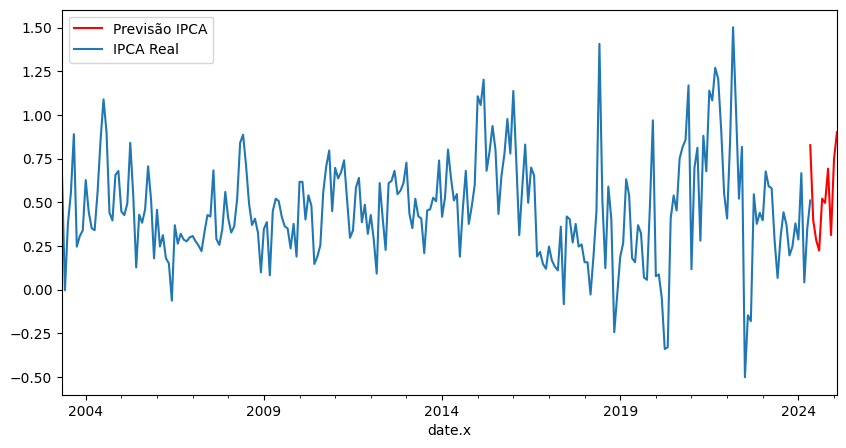

In [82]:
variables = ['swap', 'ipca_exp', 'selic', 'juro_real', 'IBC', 'IPCA_adjusted', 'M1_adjusted']
df_var = df[variables]
model = VAR(df_var)
results = model.fit(maxlags=15, ic='aic')

# Resumo do modelo
print(results.summary())

# Fazendo previsões
lag_order = results.k_ar
forecast_input = df_var.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=10, freq='M'), columns=df_var.columns)

# Plotando as previsões
forecast_df['IPCA_adjusted'].plot(figsize=(10, 5), label='Previsão IPCA', color='red')
df['IPCA_adjusted'].plot(label='IPCA Real')
plt.legend()
plt.show()

In [83]:
forecast_df['IPCA_adjusted']

2024-05-31    0.827070
2024-06-30    0.397644
2024-07-31    0.283663
2024-08-31    0.224102
2024-09-30    0.521036
2024-10-31    0.496938
2024-11-30    0.692841
2024-12-31    0.312560
2025-01-31    0.747230
2025-02-28    0.901462
Freq: ME, Name: IPCA_adjusted, dtype: float64

In [78]:
df

,month_year,swap,IPCA,IPCA_lag,ipcaanual,ipca_exp,ipca,selic,juro_real,juro_real_lag,IBC,hiato,hiato_lag,M1,M1_diff,M1_adjusted,IPCA_adjusted
date.x,,,,,,,,,,,,,,,,,
2003-04-01,2003-04,25.210000,0.97,1.23,16.769209,0.5400,9.5800,26.319000,8.178347,8.358488,101.08,0.416089,0.764971,-2411.985,-2411.985,-2442.473506,0.940486
2003-05-01,2003-05,23.290000,0.61,0.97,17.235307,0.4900,8.8700,26.308095,7.738956,8.178347,99.97,-0.405544,0.416089,-1178.836,-1178.836,77.769055,0.660757
2003-06-01,2003-06,22.290000,-0.15,0.61,16.569860,0.5500,8.0700,26.086500,8.163894,7.738956,100.14,-0.054145,-0.405544,2234.552,2234.552,-2568.697887,-0.002785
2003-07-01,2003-07,20.920000,0.20,-0.15,15.429390,0.8500,6.9100,25.360870,8.603943,8.163894,98.92,-1.270139,-0.054145,-1416.187,-1416.187,1246.223257,0.379090
2003-08-01,2003-08,20.750000,0.34,0.20,15.073870,0.5500,6.2000,23.502381,7.324435,8.603943,99.76,-0.669436,-1.270139,268.609,268.609,31.917180,0.553340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,2024-01,10.046364,0.42,0.56,4.506637,0.4276,3.8034,11.650000,6.835320,6.933482,148.54,0.497620,0.011542,-46583.260,-46583.260,-13097.800581,0.287382
2024-02-01,2024-02,9.933158,0.83,0.42,4.496274,0.3801,3.8014,11.150000,6.367429,6.835320,149.23,0.713032,0.497620,1352.501,1352.501,3161.341934,0.666986
2024-03-01,2024-03,9.835500,0.16,0.83,3.925596,0.5000,3.7007,11.000000,6.807181,6.367429,148.85,-0.088291,0.713032,30224.539,30224.539,31269.092215,0.042174
